In [66]:
import torch
import torch.nn as nn
import requests
import zipfile
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,Dataset

In [67]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Setup the Dataset


In [68]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi\pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Data exploration


In [69]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [70]:
# بعد فك الضغط
# نبحث داخل image_path عن مجلد train
for root, dirs, files in os.walk(image_path):
    if "train" in dirs and "test" in dirs:
        train_dir = Path(root) / "train"
        test_dir = Path(root) / "test"
        break

print("Train directory:", train_dir)
print("Test directory:", test_dir)


Train directory: data\pizza_steak_sushi\pizza_steak_sushi\train
Test directory: data\pizza_steak_sushi\pizza_steak_sushi\test


### Setup training and test path


In [71]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir
print(f"there are {len(os.listdir(train_dir))} classes in the training directory")
print(f"there are {len(os.listdir(test_dir))} classes in the test directory")

there are 3 classes in the training directory
there are 3 classes in the test directory


# New Section

In [72]:
import os
print("Current path:", os.getcwd())
print("Image path:", image_path)
print("Exists?", image_path.exists())
!ls -R $image_path | head -n 30


Current path: e:\Projects\0-deeplearning-pytorch\deep-learning-by-pytorch
Image path: data\pizza_steak_sushi\pizza_steak_sushi
Exists? True


'ls' is not recognized as an internal or external command,
operable program or batch file.


### Visualize the data

random image path:data\pizza_steak_sushi\pizza_steak_sushi\test\sushi\2394442.jpg and class is :sushi


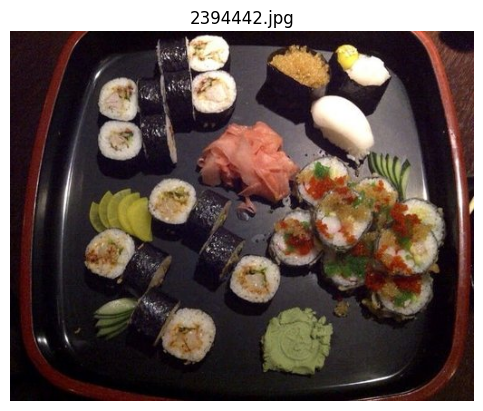

 random image path : data\pizza_steak_sushi\pizza_steak_sushi\test\sushi\2394442.jpg and class is : sushi


In [73]:
random .seed(42)
#get a random image path
image_path_list=list(image_path.glob("*/*/*.jpg"))
#print(image_path_list)
random_image_path=random.choice(image_path_list)
image_class=random_image_path.parent.stem
print(f"random image path:{random_image_path} and class is :{image_class}")
#open the image and plot it
img=Image.open(random_image_path)
#print(img)
plt.imshow(img)
plt.axis(False)
plt.title(random_image_path.name)
plt.show()
print (f" random image path : {random_image_path} and class is : {image_class}")


(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

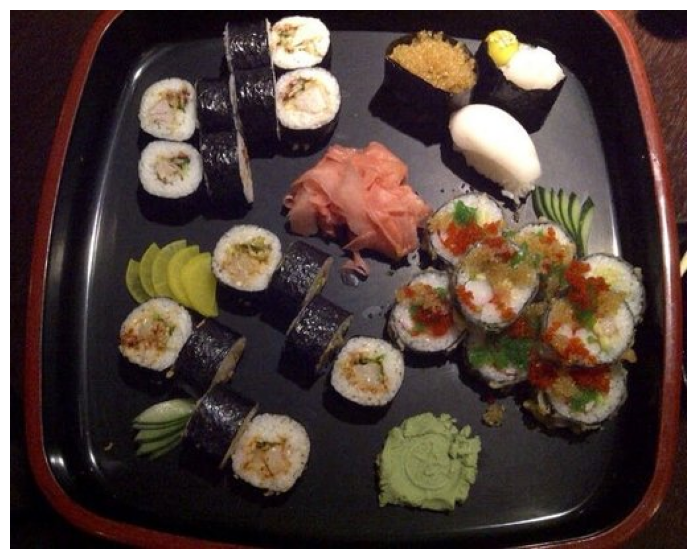

In [74]:
img_as_array=np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.axis(False)

#print(f"image as array : {img_as_array} and shape is : {img_as_array.shape}")

### TuRn ALl IMAGES InTo Tensors

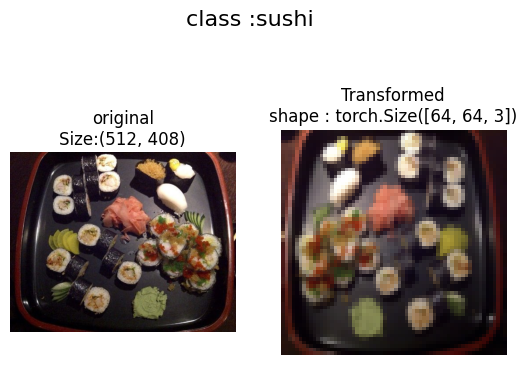

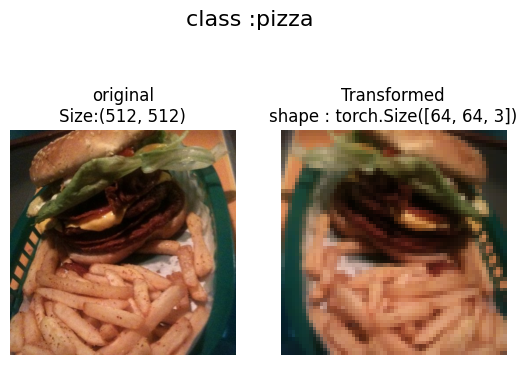

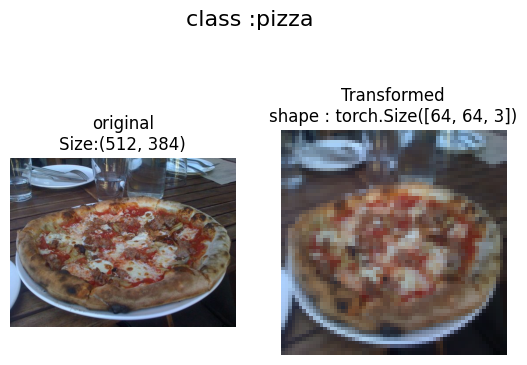

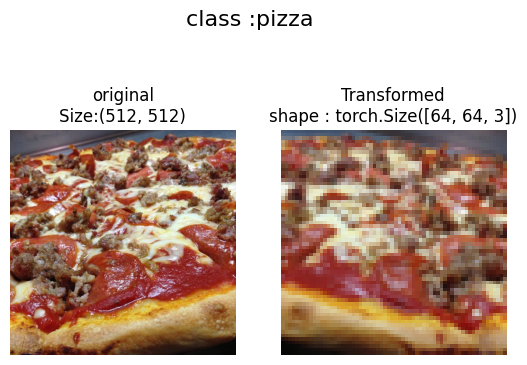

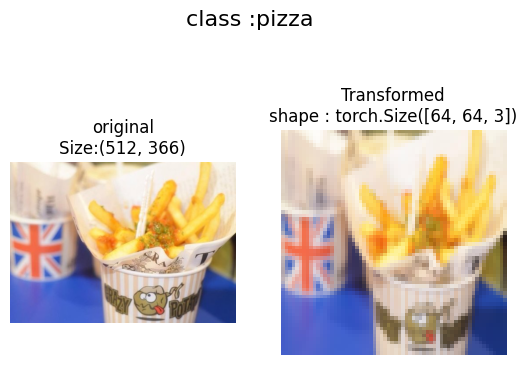

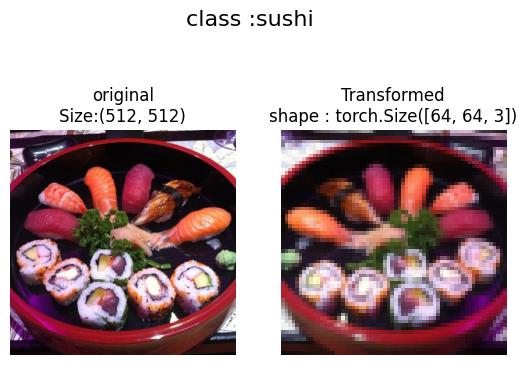

In [75]:
data_transform=transforms.Compose([# Resize the image
                                    transforms.Resize(size=(64,64)),
                                    #flip the image randomly on the horizontal axis
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    #convert the image to a tensor
                                    transforms.ToTensor()
                                    ])
def plot_transformed_images (image_paths:list,transform,n=3,seed=None):
    if seed :
        random.seed(seed)
    random_image_paths= random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax =plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"original\nSize:{f.size}")
            ax[0].axis("off")
    # Transform the image
            transformed_image=transform(f).permute(1, 2, 0)
            #ax[1].imshow(transformed_image)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nshape : {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"class :{image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_path_list,data_transform,n=6,seed=42)

### / Loading image Folder

In [76]:

# 4
test_data=datasets.ImageFolder(root=test_dir,
                                transform=data_transform,target_transform=None)
train_data =datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,target_transform=None)

In [77]:
# 4
test_data=datasets.ImageFolder(root=test_dir,
                                transform=data_transform,target_transform=None)

In [78]:
class_names=train_data.classes
class_dict=train_data.class_to_idx
print(f"class names :{class_names}")


class names :['pizza', 'steak', 'sushi']


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

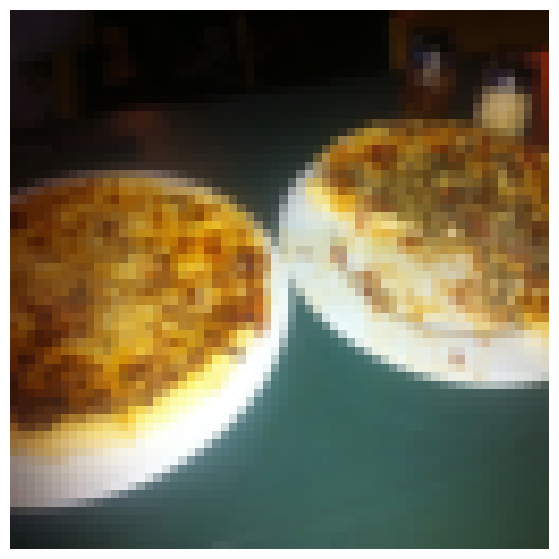

In [79]:
img,label= train_data[0][0],train_data[0][1]
img_permute=img.permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)

In [80]:
# turn loaded images into dataloader

batch_size=1
train_dataloader=DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=False)
train_dataloader

In [81]:
img, label= next(iter(train_dataloader))



## Loading image data with a custom dataset

In [82]:
from typing import Tuple,List, Dict
## Loading image data with a custom dataset
# setup the target directory structure
target_directory=train_dir
class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])



In [83]:
def find_classes(directory:str)-> Tuple[list[str],Dict[str,int]]:
    classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"couldn't find any classes in {directory}  ")
    class_to_idx={class_name:i for i ,class_name in enumerate(classes)}
    return classes,class_to_idx

In [84]:
#create a custom dataset to replicate torchvision.datasets.ImageFolder
from torch.utils.data import Dataset
from PIL import Image
import pathlib

class ImageFolderCustom(Dataset):
    def __init__(self,targ_dir:str,transform=None):
        self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        #setup transform
        self.transform=transform
        #class and class to index
        self.classes,self.class_to_idx=find_classes(targ_dir)
        #create a function to load the images
    def load_image (self,index:int )->Image.Image:
            image_path=self.paths[index]
            return Image.open(image_path)
    def __len__ (self)-> int:
        return len (self.paths)
    def __getitem__(self, index:int)-> Tuple[torch.Tensor,int]:
        img=self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx= self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img),class_idx
        else:
            return img, class_idx


In [85]:
train_transforms= transforms.Compose([ transforms.Resize(size=(64,64)),
                                        transforms.RandomHorizontalFlip(p=0.5)
                                        ,transforms.ToTensor()])
test_transforms=transforms.Compose([transforms.Resize(size=(64,64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()])
# Test out ImageFolderCustom
train_data_custom= ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)
test_data_custom=ImageFolderCustom(targ_dir=test_dir,transform=test_transforms)

In [86]:
import torch
import random
import matplotlib.pyplot as plt
from typing import List
# Create a function to take in dataset
def display_random_image (dataset: torch.utils.data.Dataset,
                            classes:List[str]=None,
                            n : int =10,
                            display_shape:bool=True,
                                seed : int =None):
    if n >10 :
        n=10
        display_shape=False
        print( f"for display , purpose , n  shouldn't be larger than 10, setting to 10 and removing shape display")
    if seed :
        random.seed(seed)
    random_sample_idx= random.sample(range(len(dataset)),k= n)
    plt.figure(figsize=(16,8))
    for i, targ_sample in enumerate (random_sample_idx):
        targ_image,targ_label=dataset[targ_sample][0],dataset[targ_sample][1]
        target_image_adjust=   targ_image.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        if classes :
          title=f"class:{classes[targ_label]}"
          if display_shape:
                title=title+ f"\n{target_image_adjust.shape}"
        plt.title(title)

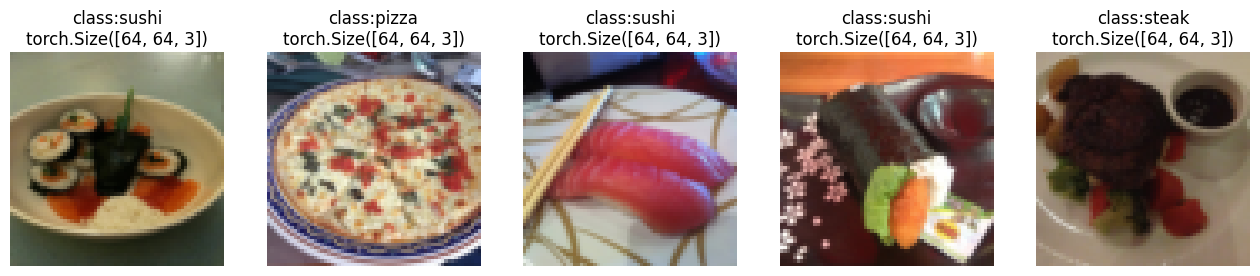

In [87]:
display_random_image(train_data, n=5, classes=class_names, seed=None)


In [88]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [89]:
batch_size=32
num_workers=0
train_dataloader_custom=DataLoader(dataset=train_data_custom,batch_size=batch_size,
                                    num_workers=num_workers
                                    ,shuffle=True)
test_dataloader_custom=DataLoader(dataset=test_data_custom,
                                    batch_size=batch_size,
                                    num_workers=num_workers,
                                    shuffle=False)
img_custom,label_custom=next(iter(train_dataloader_custom))
img_custom.shape,label_custom.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [90]:
from torchvision import transforms
train_transform=transforms.Compose([transforms.Resize(size=(244,244)),
                                                        transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                        transforms.ToTensor() ] )




In [91]:
image_path_list=list(image_path.glob("*/*/*.jpg"))

In [92]:
from torch.utils.data import DataLoader

dl = DataLoader(train_data_custom, batch_size=32, shuffle=True, num_workers=0)
batch = next(iter(dl))
print("ok", batch[0].shape, batch[1].shape)


ok torch.Size([32, 3, 64, 64]) torch.Size([32])


### PYTORCH FROM DEEP LEARNING AI

In [99]:
#import libraries
import torch 
import torch.nn as nn 
import torch.optim as optim

# Defining Data 
#Distance in miles 
distance= torch.tensor([[1.0],[2.0],[3.0],[4.0]],dtype=torch.float32)
#Delivery times in minutes
times= torch.tensor([[6.96],[12.11],[16.77],[22.21]],dtype=torch.float32)
# Distance in miles 
inputs= torch.tensor([[2.0,3.0,4.0],[6.0,7.0,8.0],[11.0,12.0,13.0],[14.0,15.0,16.0]],dtype=torch.float32)
# Delivery times in minutes 
times = torch .tensor([[14.8],[24.1],[36.5],[51.2],[60.8],[75.3]],dtype=torch.float32)
# Define the model 
model= nn.Sequential(nn.Linear(1,1))
# Define the loss function and optimizer 
loss_function = nn.MSELoss
optimizer = optim.SGD(model.parameters(),lr=0.01)



In [100]:
# Training loop 
for epoch in range (500):
    # Rest the optimizer 
    optimizer.zero_grad()
    # Make prediction 
    outputs= model(inputs)
    # Calculate the loss - how bad was this guess ?
    loss= loss_function(outputs, times )
    # Calculate  adjustments 
    loss.backward()
    # Update the model 
    optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x3 and 1x1)